# `Flax`

You may have heard of `TensorFlow`, one of the first hugely popular libraries for computing data flow graphs -- operations which we've effectively been doing much of this class, and are the underpinning of neural networks.  `Flax` is effectively `TensorFlow` built on `JAX`, and will be our main library for constructing and training neural networks.

You can install it with:

```bash
!pip install -q flax
```

In [1]:
import jax
from jax import random, numpy as jnp
from flax import linen as nn

from numpy import genfromtxt
import matplotlib.pyplot as plt

# Linear Regression as a Neural Network

We'll repeat (again) our linear regression example, but this time using `Flax` perform linear regression using a single dense neural network layer.

First let's read in the data.

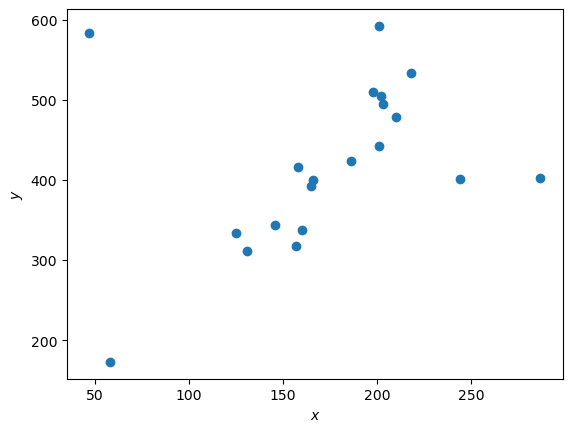

In [2]:
data = genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')

train_X = jnp.array(data['x'])
train_Y = jnp.array(data['y'])

n_samples = train_X.shape[0]
plt.scatter(train_X, train_Y)
plt.xlabel('$x$')
plt.ylabel('$y$');

Let's reshape:

In [3]:
X = data['x'].reshape(-1, 1)
y = data['y'].reshape(-1, 1)
X_tst = jnp.linspace(X.min(), X.max(), 100).reshape(-1, 1)

To replicate linear regression we just need a single dense layer with a single output.  We'll use the `flax.nn` module to define our model.

In [4]:
# We create one dense layer instance, where 'features' sets the output dimension
model = nn.Dense(features=1)

The models don't actually store the parameters, so we need to initialize them with the `init` method.  We'll use the `jax.random.PRNGKey` to seed the random number generator as we have before.

In [5]:
key1, key2 = random.split(random.PRNGKey(0)) # random keys
params = model.init(key2, X[0])       # provide an example input so it can infer the shapes
params

{'params': {'kernel': Array([[2.1127698]], dtype=float32),
  'bias': Array([0.], dtype=float32)}}

We can see that `params` has a kernel (i.e., weights, or slope in this case) and bias (y-intercept), initialized to random and zero values, respectively.

If we want to compute a forward pass of our model (i.e., plug in a `x` value and get a predicted `y` value), we can use the `apply` method.  Remember the parameters (slope and y-intercept) aren't stored in the model, so we need to provide them.

In [6]:
model.apply(params, X[0]) # example application of the model

Array([424.66675], dtype=float32)

## Cost Function

Recall that performing linear regression is equivalent to minimizing the mean squared error (MSE) between the model predictions and the data.

We're going to minimize the MSE using gradient descent, and we'll write everything from scratch as an excuse to learn how to use `Flax`.

First the cost function.  We're going to have `JAX` do some optimization with just-in-time (JIT) compiling (see [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions) for gorier details).

In [7]:
@jax.jit
def mse(params, X, Y):
    # the squared loss for a single (x, y) pair
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y - pred, y - pred)
    # vectorize this to compute the average loss over a batch of data
    return jnp.mean(jax.vmap(squared_error)(X, Y), axis=0)

In [8]:
mse(params, X, y)

Array(18225.635, dtype=float32)

In [9]:
%timeit mse(params, X, y)

19 μs ± 283 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


It works, and it's fast!  Try commenting out the `@jax.jit` decorator and rerun the two cells above to compare run times.

## Gradient Decent

Recall the algorithm for gradient decent:
$$
\mathrm{repeat~until~convergence} \{\\
\theta_j = \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta_0, \theta_1) \mathrm{~~~~for~}j=0\mathrm{~and~}j=1
\\\}
$$

where $\alpha$ is the *learning rate*.

Remember that one of `JAX`'s superpowers is that it can automatically compute gradients of functions.  `jax.value_and_grad()` will give us a function that computes the value and gradient of our MSE cost function for us.

In [10]:
loss_grad_fn = jax.value_and_grad(mse)
loss_grad_fn(params, X, y)

(Array(18225.635, dtype=float32),
 {'params': {'bias': Array([-107.2478], dtype=float32),
   'kernel': Array([[-9656.601]], dtype=float32)}})

Let's use it to update parameters during gradient decent.

In [11]:
learning_rate = 0.00001 # Gradient descent step size

@jax.jit
def update_params(params, learning_rate, grads):
    params = jax.tree_util.tree_map(
        lambda p, g: p - learning_rate * g, params, grads)
    return params

...and finally put it all together:

In [12]:
loss_vals = []
for step in range(1000):
    loss_val, grads = loss_grad_fn(params, X, y)
    params = update_params(params, learning_rate, grads)
    if step % 10 == 0: # print every 10 steps
        print(f"Step {step}, loss {loss_val}")
    loss_vals.append(loss_val)

Step 0, loss 18225.634765625
Step 10, loss 17518.630859375
Step 20, loss 17518.310546875
Step 30, loss 17517.990234375
Step 40, loss 17517.671875
Step 50, loss 17517.3515625
Step 60, loss 17517.03125
Step 70, loss 17516.712890625
Step 80, loss 17516.390625
Step 90, loss 17516.0703125
Step 100, loss 17515.75390625
Step 110, loss 17515.43359375
Step 120, loss 17515.11328125
Step 130, loss 17514.79296875
Step 140, loss 17514.474609375
Step 150, loss 17514.15234375
Step 160, loss 17513.833984375
Step 170, loss 17513.513671875
Step 180, loss 17513.193359375
Step 190, loss 17512.876953125
Step 200, loss 17512.5546875
Step 210, loss 17512.236328125
Step 220, loss 17511.916015625
Step 230, loss 17511.595703125
Step 240, loss 17511.279296875
Step 250, loss 17510.955078125
Step 260, loss 17510.63671875
Step 270, loss 17510.318359375
Step 280, loss 17509.998046875
Step 290, loss 17509.677734375
Step 300, loss 17509.359375
Step 310, loss 17509.037109375
Step 320, loss 17508.71875
Step 330, loss 17

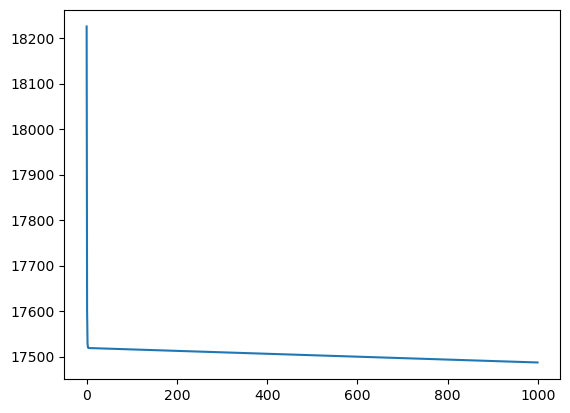

In [13]:
plt.plot(loss_vals);

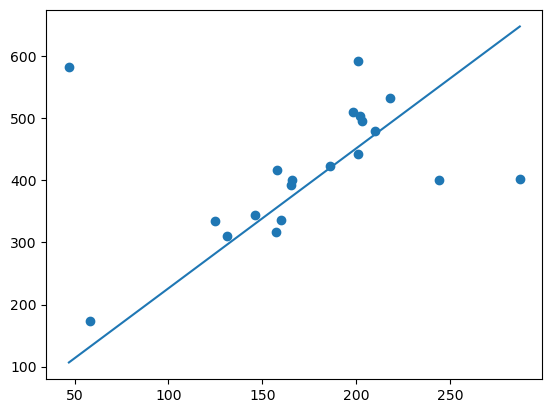

In [14]:
plt.scatter(X, y)
plt.plot(X_tst, model.apply(params, X_tst));

## Fancier Optimization


In [15]:
import optax
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(mse)

In [16]:
for i in range(1001):
  loss_val, grads = loss_grad_fn(params, X, y)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  if i % 10 == 0:
    print('Loss step {}: '.format(i), loss_val)


Loss step 0:  17487.014
Loss step 10:  17487.01
Loss step 20:  17487.002
Loss step 30:  17486.996
Loss step 40:  17486.992
Loss step 50:  17486.986
Loss step 60:  17486.98
Loss step 70:  17486.977
Loss step 80:  17486.97
Loss step 90:  17486.965
Loss step 100:  17486.959
Loss step 110:  17486.951
Loss step 120:  17486.947
Loss step 130:  17486.941
Loss step 140:  17486.936
Loss step 150:  17486.93
Loss step 160:  17486.922
Loss step 170:  17486.916
Loss step 180:  17486.912
Loss step 190:  17486.904
Loss step 200:  17486.9
Loss step 210:  17486.896
Loss step 220:  17486.889
Loss step 230:  17486.885
Loss step 240:  17486.879
Loss step 250:  17486.873
Loss step 260:  17486.865
Loss step 270:  17486.861
Loss step 280:  17486.857
Loss step 290:  17486.85
Loss step 300:  17486.846
Loss step 310:  17486.84
Loss step 320:  17486.836
Loss step 330:  17486.826
Loss step 340:  17486.822
Loss step 350:  17486.818
Loss step 360:  17486.81
Loss step 370:  17486.807
Loss step 380:  17486.799
Loss s

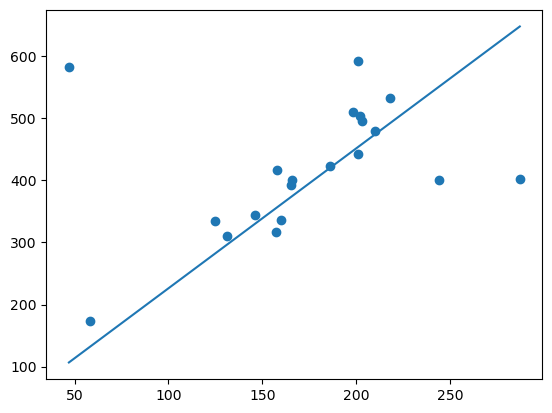

In [17]:
plt.scatter(X, y)
plt.plot(X_tst, model.apply(params, X_tst));